In [2]:
import anndata
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
import numpy as np
import os
import pandas as pd
import scanpy as sc
import scvelo as scv
import velocyto as vcy
import loompy

### Part 1: construct anndata object with Seurat data

In [2]:
# getting R matrix into scanpy
X = io.mmread("counts_all6.mtx")

In [3]:
# create anndata object
adata = anndata.AnnData(
    X=X.transpose().tocsr()
)


In [4]:
adata

AnnData object with n_obs × n_vars = 5847 × 5050

In [5]:
# loading R cell metadata:
cell_meta = pd.read_csv("metadata6.csv")
cell_meta[0:3]

,orig.ident,nCount_RNA,nFeature_RNA,RNA_snn_res.0.4,seurat_clusters,condition,barcode,UMAP_1,UMAP_2
0,Miguel_Elisa_merged2,418,330,1,1,KO,AAACCCAAGTGCGCTC-1,0.534858,3.279111
1,Miguel_Elisa_merged2,1979,1021,0,0,KO,AAACGAAAGGATTCAA-1,-1.932171,-4.925292
2,Miguel_Elisa_merged2,1130,725,2,2,KO,AAACGAAAGGTAAGAG-1,-4.291678,-0.002013


In [6]:
# load gene names:
with open("gene_names6.csv", 'r') as f:
    gene_names = f.read().splitlines()

In [7]:
# set anndata observations and index obs by barcodes, var by gene names
adata.obs = cell_meta
adata.obs.index = adata.obs['barcode']
adata.var.index = gene_names

In [8]:
# load dimensional reduction:
pca = pd.read_csv("pca6.csv")
pca.index = adata.obs.index

In [9]:
# set pca and umap
adata.obsm['X_pca'] = pca.to_numpy()
adata.obsm['X_umap'] = np.vstack((adata.obs['UMAP_1'].to_numpy(), adata.obs['UMAP_2'].to_numpy())).T

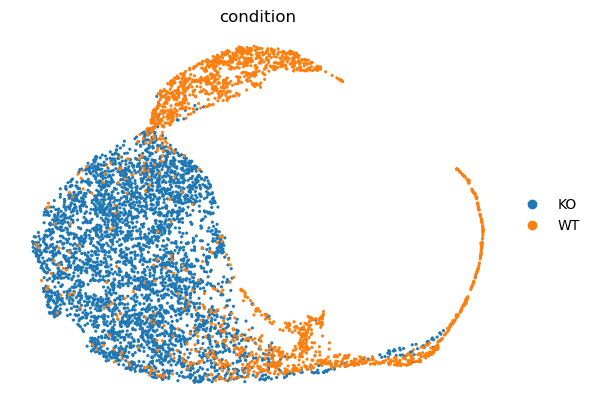

In [10]:
# plot a UMAP colored by sampleID to test:
sc.pl.umap(adata, color=['condition'], frameon=False, save=True)

In [12]:
# save dataset as anndata format
adata.write('my_data6.h5ad')

In [3]:
#reload dataset
adata = sc.read_h5ad('my_data6.h5ad')

### Part 2: get velocyto data in (spliced/unspliced reads)

In [4]:
scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo', facecolor='white', dpi=100, frameon=False)

In [5]:
KO_loom = scv.read("KO.loom", cache=True)
WT_loom = scv.read("WT.loom", cache=True)

In [6]:
# rename barcodes in order to merge:
barcodes = [bc.split(':')[1] for bc in KO_loom.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '-1' for bc in barcodes]
KO_loom.obs.index = barcodes

In [7]:
KO_loom.obs.index[0:3]

Index(['AAATGGACAGGCATGA-1', 'AACAAAGAGTAAGGGA-1', 'AACCACAGTGCCGAAA-1'], dtype='object')

In [8]:
# rename barcodes in order to merge:
barcodes = [bc.split(':')[1] for bc in WT_loom.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '-2' for bc in barcodes]
WT_loom.obs.index = barcodes

In [9]:
WT_loom.obs.index[0:3]

Index(['AAAGAACAGACAACTA-2', 'AATCGTGGTTAGAGAT-2', 'AACGTCAGTAGATGTA-2'], dtype='object')

In [10]:
KO_loom.var_names_make_unique()
WT_loom.var_names_make_unique()

In [11]:
#mergin both
merged_loom = KO_loom.concatenate(WT_loom)

In [12]:
merged_loom

AnnData object with n_obs × n_vars = 5847 × 5050
    obs: 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [13]:
adata

AnnData object with n_obs × n_vars = 5847 × 5050
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.4', 'seurat_clusters', 'condition', 'barcode', 'UMAP_1', 'UMAP_2'
    uns: 'condition_colors'
    obsm: 'X_pca', 'X_umap'

In [14]:
# merge matrices into the original adata object
adata_merged = scv.utils.merge(merged_loom, adata)


In [15]:
adata

AnnData object with n_obs × n_vars = 5847 × 5050
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.4', 'seurat_clusters', 'condition', 'barcode', 'UMAP_1', 'UMAP_2', 'sample_batch'
    uns: 'condition_colors'
    obsm: 'X_pca', 'X_umap'

In [16]:
adata_merged

AnnData object with n_obs × n_vars = 5847 × 5050
    obs: 'batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'sample_batch', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.4', 'seurat_clusters', 'condition', 'barcode', 'UMAP_1', 'UMAP_2'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'condition_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

### Part 3: Velocities

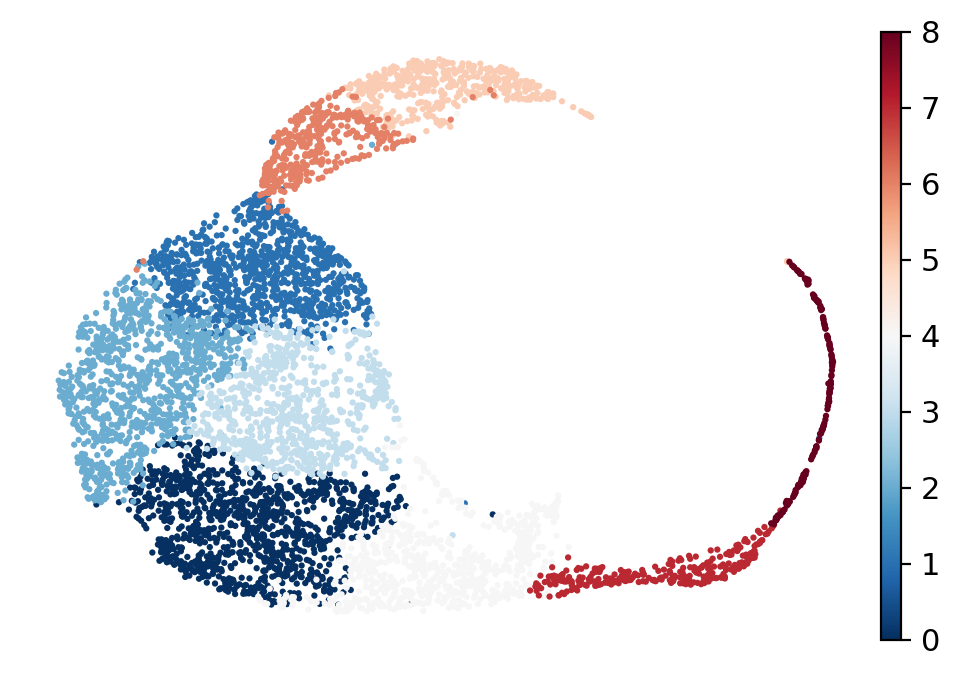

In [17]:
#just checking
sc.pl.umap(adata, color='seurat_clusters', frameon=False, legend_loc='on data', title='')

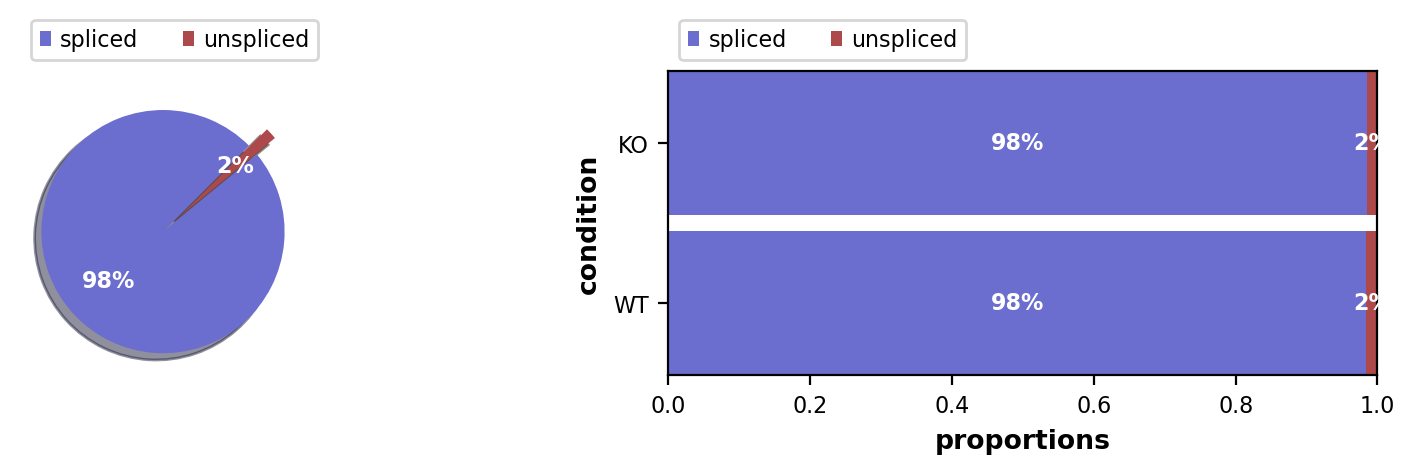

In [18]:
# checking that spliced vs unspliced still ok
scv.pl.proportions(adata_merged, groupby='condition')


In [19]:
# pre processing
scv.pp.filter_and_normalize(adata_merged)

Normalized count data: X, spliced, unspliced.
Logarithmized X.


In [20]:
# pre processing
scv.pp.moments(adata_merged)

computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [21]:
# computing velocities 
scv.tl.velocity(adata_merged, mode='stochastic')

computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [22]:
# same
scv.tl.velocity_graph(adata_merged)

computing velocity graph (using 1/20 cores)


  0%|          | 0/5847 [00:00<?, ?cells/s]

    finished (0:00:14) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


### Part 4: Visualizations

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


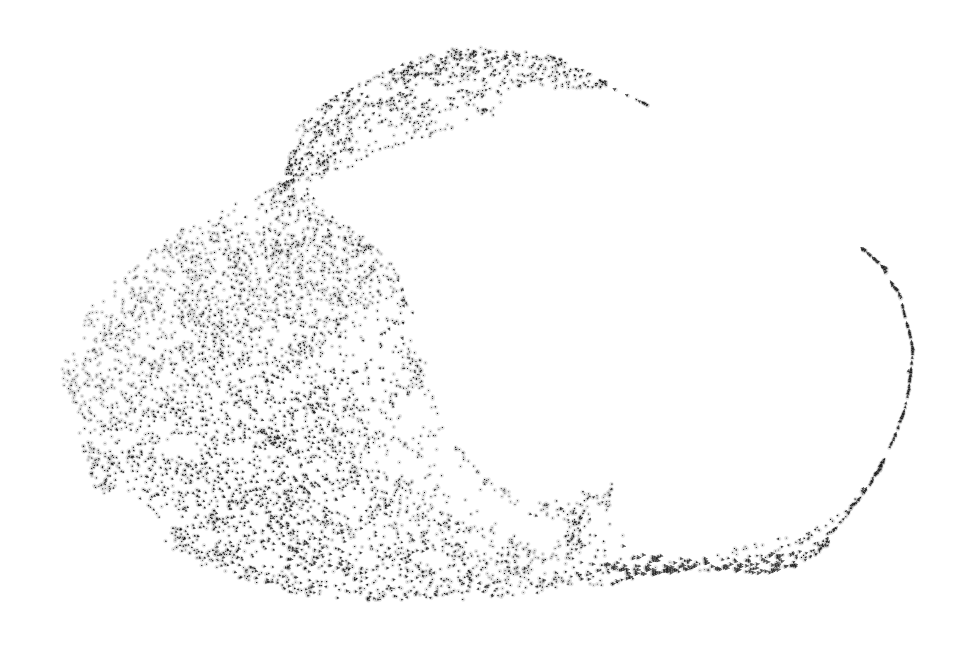

In [23]:
scv.pl.velocity_embedding(adata_merged, basis='umap', frameon=False)

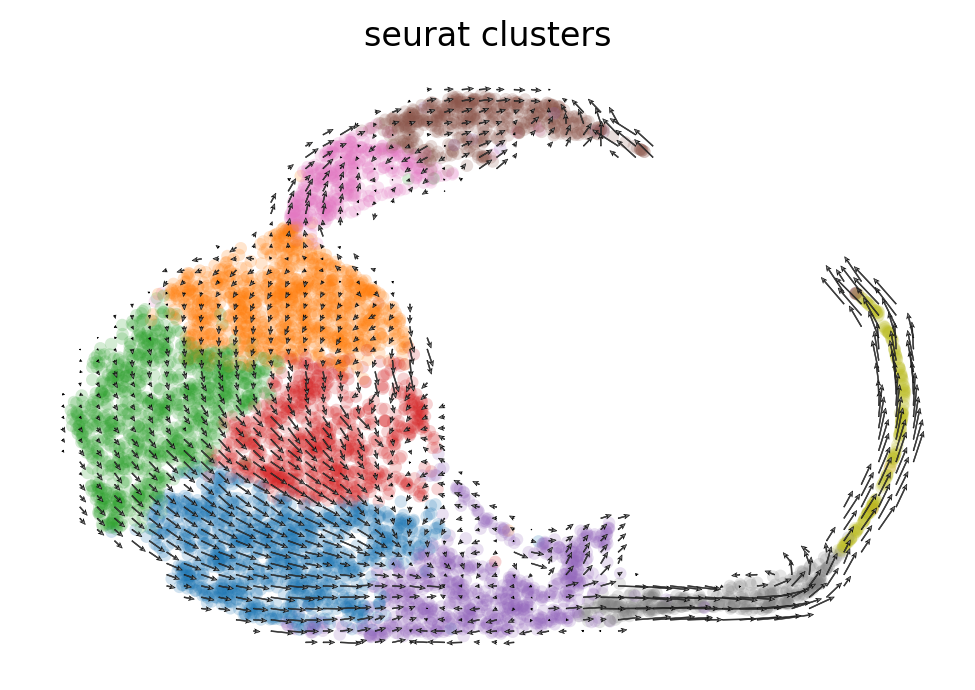

In [24]:
scv.pl.velocity_embedding_grid(adata_merged, basis='umap', color='seurat_clusters', scale=0.25)


saving figure to file ./figures/scvelo_velocities.pdf


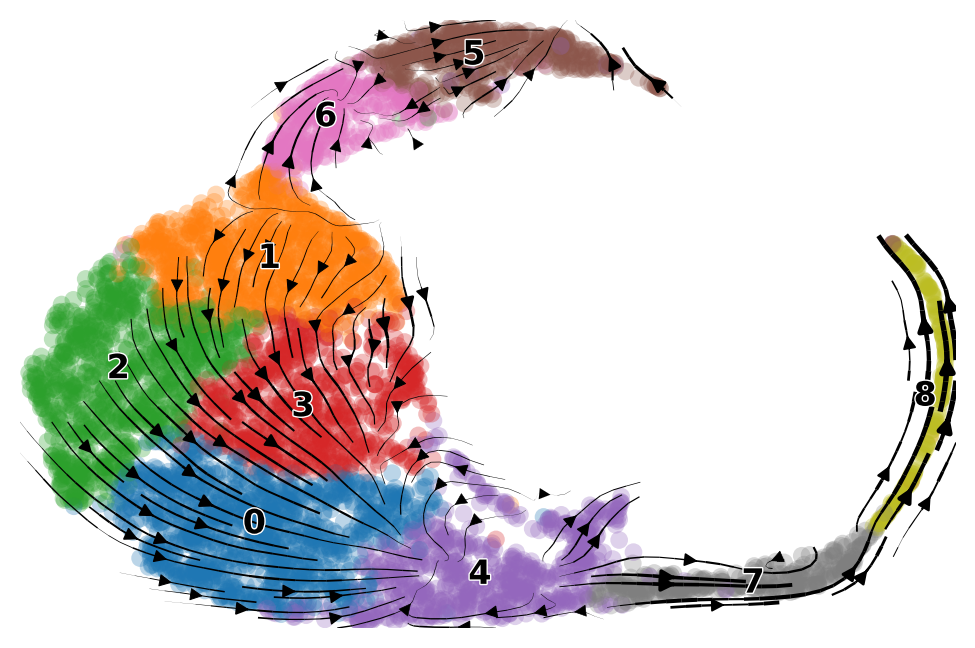

In [25]:
scv.pl.velocity_embedding_stream(adata_merged, basis='umap', color=['seurat_clusters'], save="velocities.pdf",title='')
